<a href="https://colab.research.google.com/github/DeniseGGarcia/Projetos/blob/main/Analise%20Global%20da%20Evolu%C3%A7%C3%A3o%20do%20Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desafio Final: Análise Global da Evolução do Câncer (2015–2024)

##**Objetivo:**
###Realizar uma análise exploratória e preditiva para identificar padrões temporais, regionais e demográficos relacionados à incidência de câncer no mundo, com foco em apoiar políticas públicas de prevenção. Dica: usar como target a coluna Target_Severity_Score.

### **Dicionário de Variáveis:**

* **Patient_ID** - Identificador único do paciente

* **Age** - Idade

* **Gender** - Gênero

* **Country_Region** - País/Região

* **Year** - Ano do registro

* **Genetic_Risk** - Risco genético (0-100)

* **Air_Pollution** - Exposição à poluição do ar (0-100)

* **Alcohol_Use** - Consumo de álcool (0-100)

* **Smoking** - Tabagismo (0-100)

* **Obesity_Level** - Obesidade (0-100)

* **Cancer_Type** - Tipo de câncer

* **Cancer_Stage** - Estágio do câncer

* **Treatment_Cost_USD** - Custo do tratamento (USD)

* **Survival_Years** - Anos de sobrevida

* **Target_Severity_Score** - Score de severidade (target preditivo)

## Importações:

In [ ]:
# Importações
!pip install xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

# Montando o Drive para carregar o arquivo
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

file_id = "1Mu7Z1TFQCzfoO8iL5olnmGB1RtZwr2CY"

url = f"https://drive.google.com/uc?id={file_id}&export=download"

df = pd.read_csv(url)

df.head()

Mounted at /content/drive


,Patient_ID,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
0,PT0000000,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.9,4.92
1,PT0000001,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,12573.41,4.7,4.65
2,PT0000002,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,7.1,5.84
3,PT0000003,40,Male,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,67446.25,1.6,3.12
4,PT0000004,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,77977.12,2.9,3.62


## Visão geral do dataset e suas estatísticas:

In [ ]:
# Visão geral do df
print("\nInformações do dataset:")
df.info()


Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Patient_ID             50000 non-null  object 
 1   Age                    50000 non-null  int64  
 2   Gender                 50000 non-null  object 
 3   Country_Region         50000 non-null  object 
 4   Year                   50000 non-null  int64  
 5   Genetic_Risk           50000 non-null  float64
 6   Air_Pollution          50000 non-null  float64
 7   Alcohol_Use            50000 non-null  float64
 8   Smoking                50000 non-null  float64
 9   Obesity_Level          50000 non-null  float64
 10  Cancer_Type            50000 non-null  object 
 11  Cancer_Stage           50000 non-null  object 
 12  Treatment_Cost_USD     50000 non-null  float64
 13  Survival_Years         50000 non-null  float64
 14  Target_Severity_Score  50000 

In [ ]:
df.shape

(50000, 15)

In [ ]:
# Estatísticas gerais dos dados numéricos
print("\nEstatísticas descritivas dos dados numéricos:")
df.describe()


Estatísticas descritivas dos dados numéricos:


,Age,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,54.421540,2019.480520,5.001698,5.010126,5.010880,4.989826,4.991176,52467.298239,5.006462,4.951207
std,20.224451,2.871485,2.885773,2.888399,2.888769,2.881579,2.894504,27363.229379,2.883335,1.199677
min,20.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5000.050000,0.000000,0.900000
25%,37.000000,2017.000000,2.500000,2.500000,2.500000,2.500000,2.500000,28686.225000,2.500000,4.120000
50%,54.000000,2019.000000,5.000000,5.000000,5.000000,5.000000,5.000000,52474.310000,5.000000,4.950000
75%,72.000000,2022.000000,7.500000,7.500000,7.500000,7.500000,7.500000,76232.720000,7.500000,5.780000
max,89.000000,2024.000000,10.000000,10.000000,10.000000,10.000000,10.000000,99999.840000,10.000000,9.160000


In [ ]:
# Estatísticas gerais dos dados categóricos
print("\nEstatísticas descritivas dos dados categóricos:")
df.describe(include='object')


Estatísticas descritivas dos dados categóricos:


,Patient_ID,Gender,Country_Region,Cancer_Type,Cancer_Stage
count,50000,50000,50000,50000,50000
unique,50000,3,10,8,5
top,PT0049983,Male,Australia,Colon,Stage II
freq,1,16796,5092,6376,10124


##Limpeza dos dados:

In [ ]:
# Valores básicos do número pro genero
df['Gender'].value_counts()

,count
Gender,
Male,16796
Female,16709
Other,16495


Verificamos valores incoerentes, como Homem com Cancer Cervical/Mama (Cancer de Mama em Homens ocorre de 0,5 a 1%) [fonte: https://www.who.int/news-room/fact-sheets/detail/breast-cancer.) e Mulheres com Cancer de Prostata.

In [ ]:
# Verificando a contagem de dados incoerentes
invalido = (
    ((df['Gender'] == 'Female') & (df['Cancer_Type'].str.contains('prostate', case=False, na=False))) |
    ((df['Gender'] == 'Male') & (df['Cancer_Type'].str.contains('cervical|breast', case=False, na=False)))
)

print(f"Linhas inválidas encontradas: {invalido.sum()}")

Linhas inválidas encontradas: 6221


In [ ]:
# Separar casos incoerentes (Female-Prostate e Male-Cervical)
cond_incoerente = (
    ((df['Gender'] == 'Female') & (df['Cancer_Type'].str.contains('prostate', case=False, na=False))) |
    ((df['Gender'] == 'Male') & (df['Cancer_Type'].str.contains('cervical', case=False, na=False)))
)

# Separar casos Male-Breast
cond_male_breast = (
    (df['Gender'] == 'Male') &
    (df['Cancer_Type'].str.contains('breast', case=False, na=False))
)

# Amostrar 1% dos casos Male-Breast - com seed para reprodutibilidade
male_breast_1pct = df[cond_male_breast].sample(frac=0.01, random_state=42)

# Manter:
# - Todos os dados válidos (não incoerentes e não Male-Breast)
# - + 1% amostrado de Male-Breast
df_cancer = pd.concat([
    df[~cond_incoerente & ~cond_male_breast],
    male_breast_1pct
], ignore_index=True)

# Resetar index e exibir quantidade de linhas após a limpeza
df_cancer = df_cancer.reset_index(drop=True)
print(f"Número final de linhas após limpeza: {df_cancer.shape[0]}")

Número final de linhas após limpeza: 43800


In [ ]:
# Estatísticas gerais dos dados numéricos após limpeza
print("\nEstatísticas descritivas dos dados numéricos após limpeza dos dados:")
df_cancer.describe()


Estatísticas descritivas dos dados numéricos após limpeza dos dados:


,Age,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,54.417968,2019.485708,5.005692,5.015527,5.007534,4.988331,4.990932,52493.272190,5.003550,4.951482
std,20.227674,2.873836,2.888920,2.889128,2.886004,2.882519,2.896902,27380.706998,2.882144,1.200088
min,20.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5000.050000,0.000000,0.900000
25%,37.000000,2017.000000,2.500000,2.500000,2.500000,2.500000,2.500000,28674.577500,2.500000,4.120000
50%,54.000000,2019.000000,5.000000,5.000000,5.000000,5.000000,5.000000,52494.820000,5.000000,4.950000
75%,72.000000,2022.000000,7.500000,7.500000,7.500000,7.500000,7.500000,76295.290000,7.500000,5.790000
max,89.000000,2024.000000,10.000000,10.000000,10.000000,10.000000,10.000000,99999.840000,10.000000,9.160000


In [ ]:
# Estatísticas gerais dos dados categóricos após limpeza
print("\nEstatísticas descritivas dos dados categóricos após limpeza dos dados:")
df_cancer.describe(include='object')


Estatísticas descritivas dos dados categóricos após limpeza dos dados:


,Patient_ID,Gender,Country_Region,Cancer_Type,Cancer_Stage
count,43800,43800,43800,43800,43800
unique,43800,3,10,8,5
top,PT0041333,Other,Australia,Colon,Stage II
freq,1,16495,4496,6376,8882


## Análise da distribuição dos dados numéricos:

In [ ]:
# Selecionar colunas numéricas
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()

# Excluir Patient_ID (que é object e não estará na lista)
if "Patient_ID" in num_cols:
    num_cols.remove("Patient_ID")

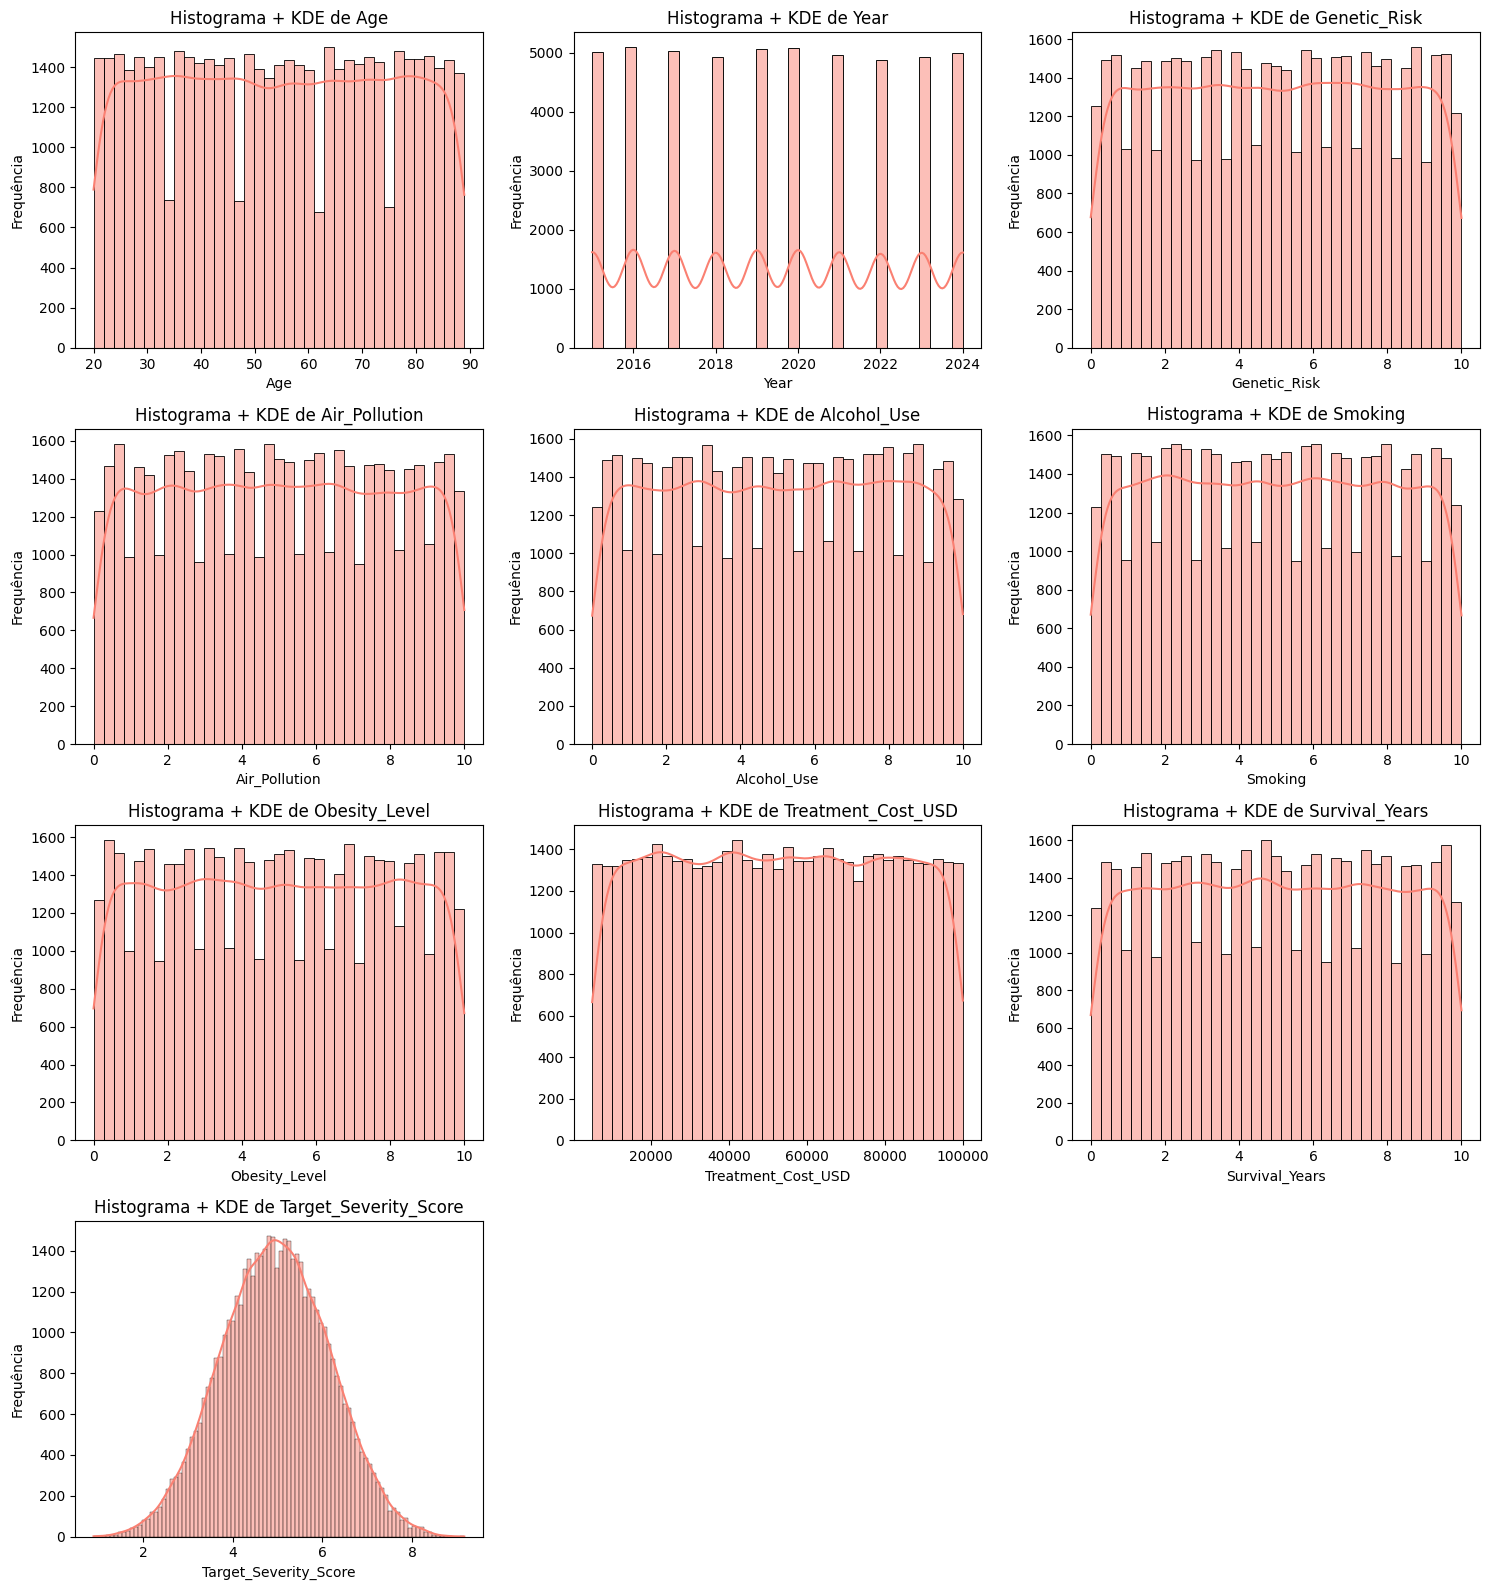

In [ ]:
# Suponha que num_cols seja sua lista de colunas numéricas
num_cols = df_cancer.select_dtypes(include='number').columns.tolist()

# Número de linhas e colunas no grid
n_cols = 3
n_rows = -(-len(num_cols) // n_cols)  # arredondamento para cima

# Criar os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

# Plotar histograma + KDE para cada coluna numérica
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color="salmon")
    axes[i].set_title(f"Histograma + KDE de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequência")

# Remover subplots vazios
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


##Possíveis Outliers:

In [ ]:
# Selecionar colunas numéricas
num_cols = ['Age', 'Treatment_Cost_USD', 'Survival_Years']
z_scores = df_cancer[num_cols].apply(zscore)

# Filtra linhas com pelo menos um z-score acima de 3 ou abaixo de -3
outliers = df_cancer[(abs(z_scores) > 3).any(axis=1)]

print(f"Número de possíveis outliers: {len(outliers)}")

Número de possíveis outliers: 0


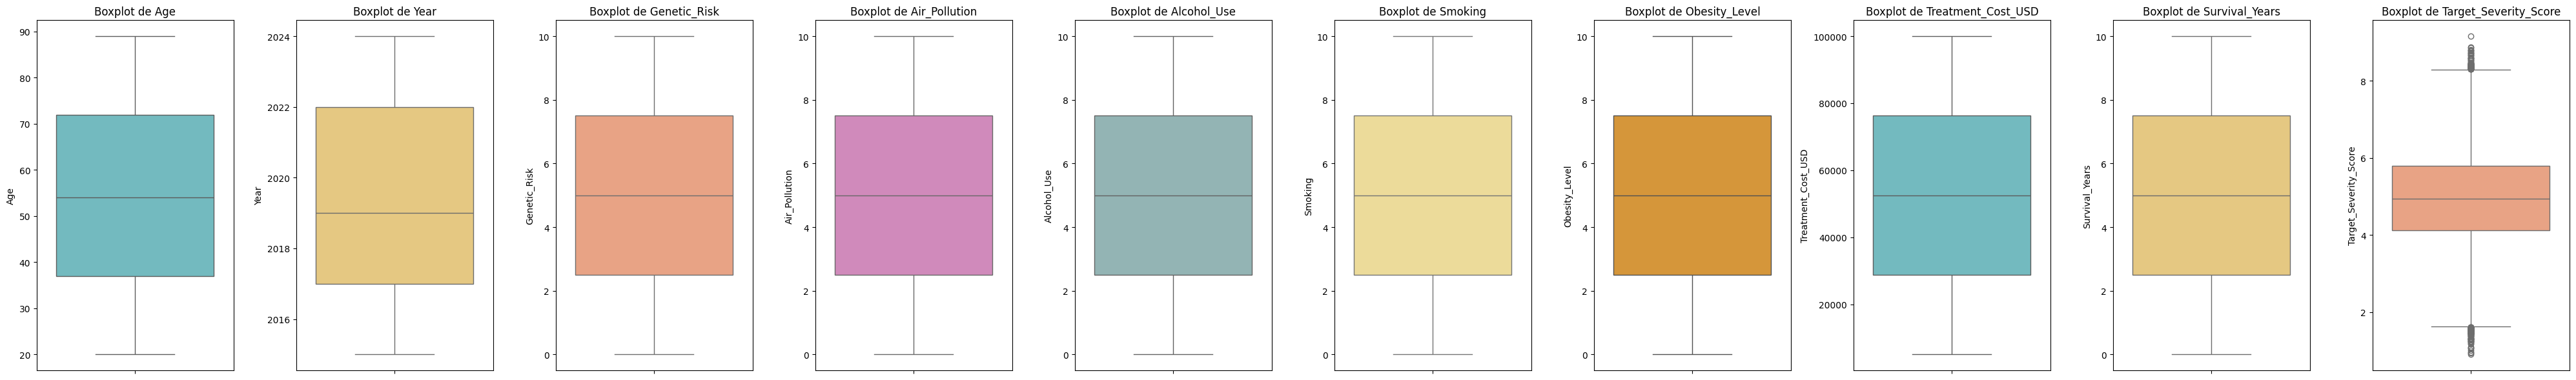

In [ ]:
# Seleciona as colunas numéricas
num_cols = df_cancer.select_dtypes(include=['number']).columns

# Paleta pastel
cores_pastel = ['#66c5cc', '#f6cf71', '#f89c74', '#dc7ec0', '#8eb9b9', '#fae38c', '#ef9b20']
cores_usadas = (cores_pastel * ((len(num_cols) // len(cores_pastel)) + 1))[:len(num_cols)]

# Define o tamanho da figura
plt.figure(figsize=(len(num_cols) * 4, 6))

# Cria um boxplot para cada coluna numérica com cor pastel
for i, (col, cor) in enumerate(zip(num_cols, cores_usadas), 1):
    plt.subplot(1, len(num_cols), i)
    sns.boxplot(y=df_cancer[col], color=cor)
    plt.title(f'Boxplot de {col}')
    plt.tight_layout()

plt.show()

##Identificar os países com maior número de casos:

In [ ]:
#Contagem de casos por país

casos_por_pais = df_cancer['Country_Region'].value_counts()

pais_mais_casos = casos_por_pais.idxmax()
qtd_mais_casos = casos_por_pais.max()

print(f"O país com mais casos é: {pais_mais_casos} ({qtd_mais_casos} casos)")

O país com mais casos é: Australia (4496 casos)


In [ ]:
# Contar os casos por país — forma mais robusta
cases_by_country = (
    df_cancer.groupby("Country_Region")
    .size()
    .reset_index(name="Case_Count")
    .sort_values(by="Case_Count", ascending=False)
)

# Plotar com Plotly com rótulos
fig = px.bar(
    cases_by_country,
    x="Case_Count",
    y="Country_Region",
    orientation="h",
    title="Número de Casos por País (2015–2024)",
    color="Country_Region",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    text="Case_Count"
)

# Define a posição dos rótulos
fig.update_traces(
    textposition="outside"
)

# Define o range dinamicamente
min_val = cases_by_country["Case_Count"].min()
max_val = cases_by_country["Case_Count"].max()

# Layout final
fig.update_layout(
    xaxis=dict(
        title="Número de Casos",
        range=[min_val - 100, max_val + 100]
    ),
    yaxis_title="País",
    height=500,
    showlegend=False
)

fig.show()


##Avaliar evolução temporal (2015–2024) da incidência:

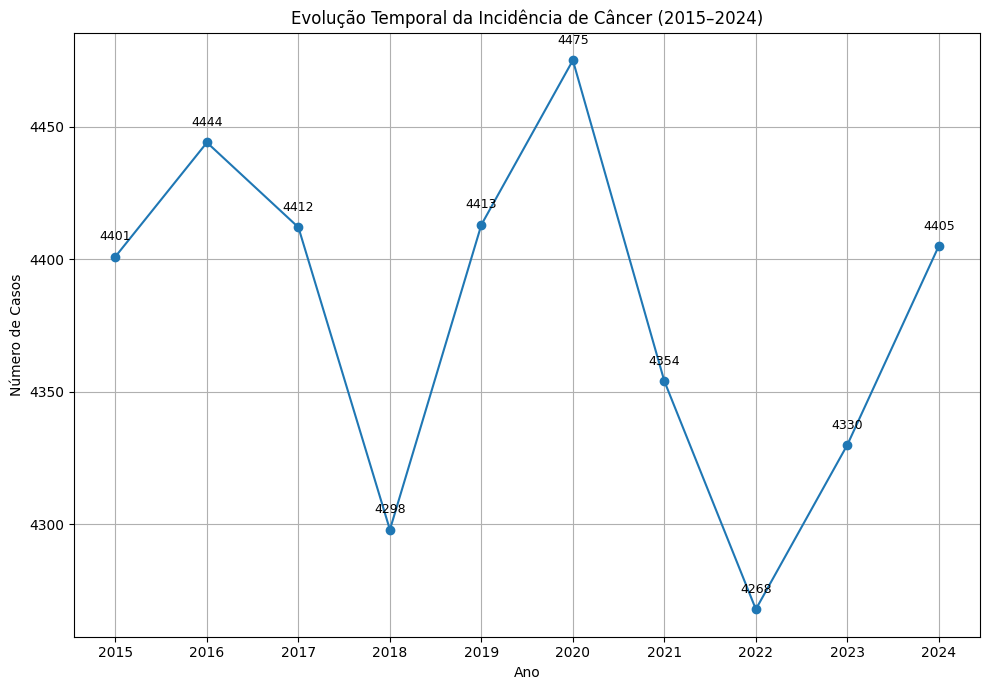

In [ ]:
#Filtrando ano de interesse 2015 a 2024

df_filtrado = df_cancer[(df_cancer['Year'] >= 2015) & (df_cancer['Year'] <= 2024)]
casos_por_ano = df_filtrado['Year'].value_counts().sort_index()

ax = casos_por_ano.plot(
    kind='line',
    marker='o',
    figsize=(10,7),
    title='Evolução Temporal da Incidência de Câncer (2015–2024)'
)

plt.xlabel('Ano')
plt.ylabel('Número de Casos')
plt.grid(True)
plt.xticks(range(2015, 2025))
plt.tight_layout()

# Adiciona rótulos em cada ponto da linha
for x, y in casos_por_ano.items():
    ax.text(x, y + 5, str(y), ha='center', va='bottom', fontsize=9)

plt.show()

##Analisar diferenças por gênero, idade ou tipo de câncer:





###Gênero

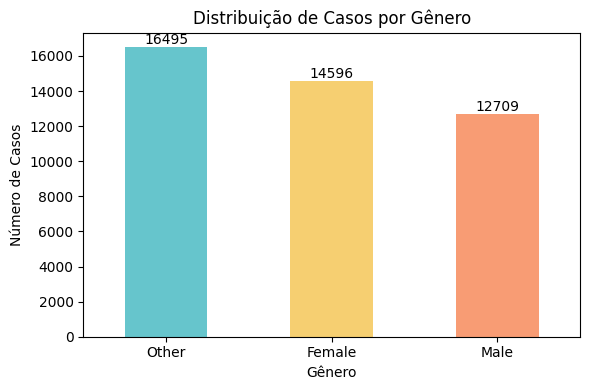

In [ ]:
# Quantidade de casos por gênero
casos_por_genero = df_cancer['Gender'].value_counts()

cores_hex = ['#66c5cc', '#f6cf71', '#f89c74', '#dc7ec0', '#8eb9b9', '#fae38c', '#ef9b20']

# Pega apenas as cores necessárias
cores_usadas = cores_hex[:len(casos_por_genero)]

# Plot
ax = casos_por_genero.plot(
    kind='bar',
    title='Distribuição de Casos por Gênero',
    figsize=(6, 4),
    color=cores_usadas
)

plt.xlabel('Gênero')
plt.ylabel('Número de Casos')
plt.xticks(rotation=0)
plt.tight_layout()

# Adiciona rótulos acima das barras
for i, v in enumerate(casos_por_genero):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()


In [ ]:
# Distribuição dos casos por gênero em gráfico de pizza
colors = ['#f89c74', "#f6cf71", '#66c5cc']

fig = px.pie(
    names=casos_por_genero.index,
    values=casos_por_genero.values,
    title="Distribuição de Casos por Gênero",
    color=casos_por_genero.index,
    color_discrete_map={
        "Male": colors[0],
        "Female": colors[1],
        "Other": colors[2]
    },
    hole=0.4
)

fig.update_traces(textinfo="percent+label", textfont_size=14)

fig.show()

In [ ]:
# Heatmap
# Paleta pastel convertida para contínuo
pastel_continuous = [
    [0.0, '#66c5cc'],
    [0.16, '#f6cf71'],
    [0.32, '#f89c74'],
    [0.48, '#dc7ec0'],
    [0.64, '#8eb9b9'],
    [0.80, '#fae38c'],
    [1.0, '#ef9b20']
]

# Criação da faixa etária
bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89']
df_cancer['Age_Range'] = pd.cut(df_cancer['Age'], bins=bins, labels=labels, right=False)

# Agrupamento
gender_age_type_group = df_cancer[['Patient_ID', 'Gender', 'Age_Range', 'Cancer_Type']]\
    .groupby(['Gender', 'Age_Range', 'Cancer_Type'], observed=False).count()\
    .rename(columns={'Patient_ID': 'Total_Patients'})\
    .reset_index()

# Gráfico
fig = px.density_heatmap(
    gender_age_type_group,
    x='Age_Range',
    y='Cancer_Type',
    z='Total_Patients',
    facet_col='Gender',
    color_continuous_scale=pastel_continuous,
    title='Heatmap de Pacientes por Gênero, Faixa Etária e Tipo de Câncer'
)

fig.update_layout(
    width=1100,
    height=500
)

fig.show()


In [ ]:
# Teste ANOVA para responder: A média da severidade é diferente entre os gêneros?
# Separar os grupos por gênero
grupo_m = df_cancer[df_cancer['Gender'] == 'Male']['Target_Severity_Score']
grupo_f = df_cancer[df_cancer['Gender'] == 'Female']['Target_Severity_Score']
grupo_o = df_cancer[df_cancer['Gender'] == 'Other']['Target_Severity_Score']

# Teste ANOVA
stat, p = f_oneway(grupo_m, grupo_f, grupo_o)

print(f'Estatística F: {stat:.3f}')
print(f'Valor-p: {p:.4f}')

if p < 0.05:
    print('✅ Diferença estatística significativa entre os gêneros.')
else:
    print('🔍 Não há diferença estatística significativa entre os gêneros.')

Estatística F: 1.172
Valor-p: 0.3097
🔍 Não há diferença estatística significativa entre os gêneros.


###Idade

In [ ]:
#Criando faixas de idade

bins = [0, 18, 30, 45, 60, 75, 100]
labels = ['0-18', '19-30', '31-45', '46-60', '61-75', '76+']
df_cancer['Faixa_Etaria'] = pd.cut(df_cancer['Age'], bins=bins, labels=labels, right=False)

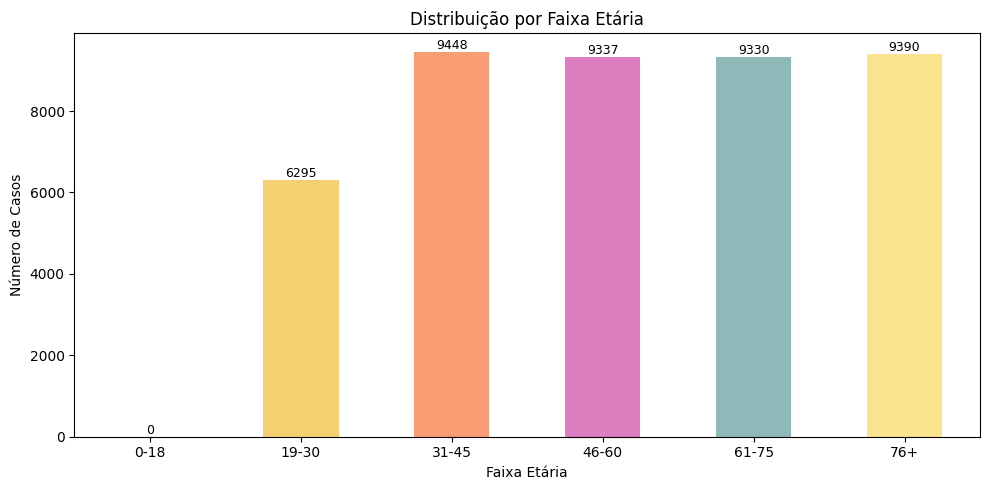

In [ ]:
# Dados
casos_por_idade = df_cancer['Faixa_Etaria'].value_counts().sort_index()

# Paleta pastel em hexadecimal
cores_pastel = ['#66c5cc', '#f6cf71', '#f89c74', '#dc7ec0', '#8eb9b9', '#fae38c', '#ef9b20']
cores_usadas = cores_pastel[:len(casos_por_idade)]

# Plot
ax = casos_por_idade.plot(
    kind='bar',
    title='Distribuição por Faixa Etária',
    figsize=(10, 5),
    color=cores_usadas
)

plt.xlabel('Faixa Etária')
plt.ylabel('Número de Casos')
plt.xticks(rotation=0)
plt.tight_layout()

# Rótulos nas barras
for i, v in enumerate(casos_por_idade):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=9)

plt.show()

###Tipo de câncer

In [ ]:
# Agrupar e calcular a média de severidade por tipo de câncer
media_tipo_cancer = df_cancer.groupby('Cancer_Type')['Target_Severity_Score'].mean().reset_index()

# Gráfico de barras
fig = px.bar(
    media_tipo_cancer,
    x='Cancer_Type',
    y='Target_Severity_Score',
    title='Média da Severidade por Tipo de Câncer',
    labels={
        'Cancer_Type': 'Tipo de Câncer',
        'Target_Severity_Score': 'Média da Severidade'
    },
    color='Cancer_Type',
    text_auto='.4s',
    color_discrete_sequence=px.colors.qualitative.Set3
)

# Adiciona rótulos com os valores arredondados
fig.update_traces(
    text=media_tipo_cancer['Target_Severity_Score'],
    textposition='outside'
)

# Layout final
fig.update_layout(
    template='plotly_white',
    showlegend=False,
    yaxis = {'type': 'log'}, # Neste caso utilizamos o 'log', pois os valores são tão próximos que não é possível enxergar as diferenças sem utilizá-lo
    xaxis_tickangle=-45
)

fig.show()

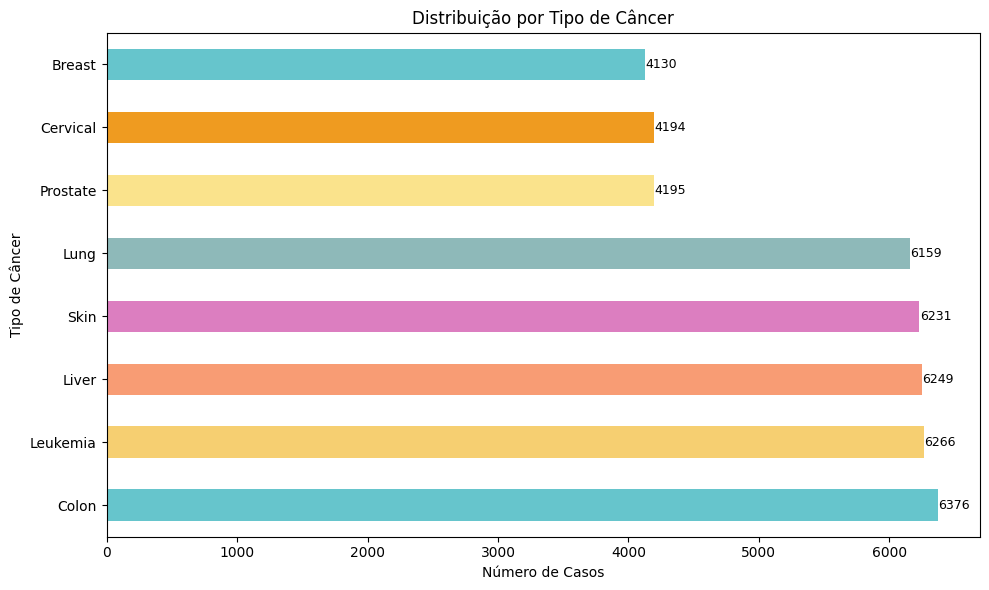

In [ ]:
# Distribuição de casos por tipo de cancer
casos_por_tipo = df_cancer['Cancer_Type'].value_counts()

# Paleta pastel
cores_pastel = ['#66c5cc', '#f6cf71', '#f89c74', '#dc7ec0', '#8eb9b9', '#fae38c', '#ef9b20']
cores_usadas = (cores_pastel * ((len(casos_por_tipo) // len(cores_pastel)) + 1))[:len(casos_por_tipo)]

# Plot horizontal
ax = casos_por_tipo.plot(
    kind='barh',
    figsize=(10, 6),
    title='Distribuição por Tipo de Câncer',
    color=cores_usadas
)

plt.xlabel('Número de Casos')
plt.ylabel('Tipo de Câncer')

# Adiciona os rótulos nas barras
for i, v in enumerate(casos_por_tipo):
    ax.text(v + 1, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()


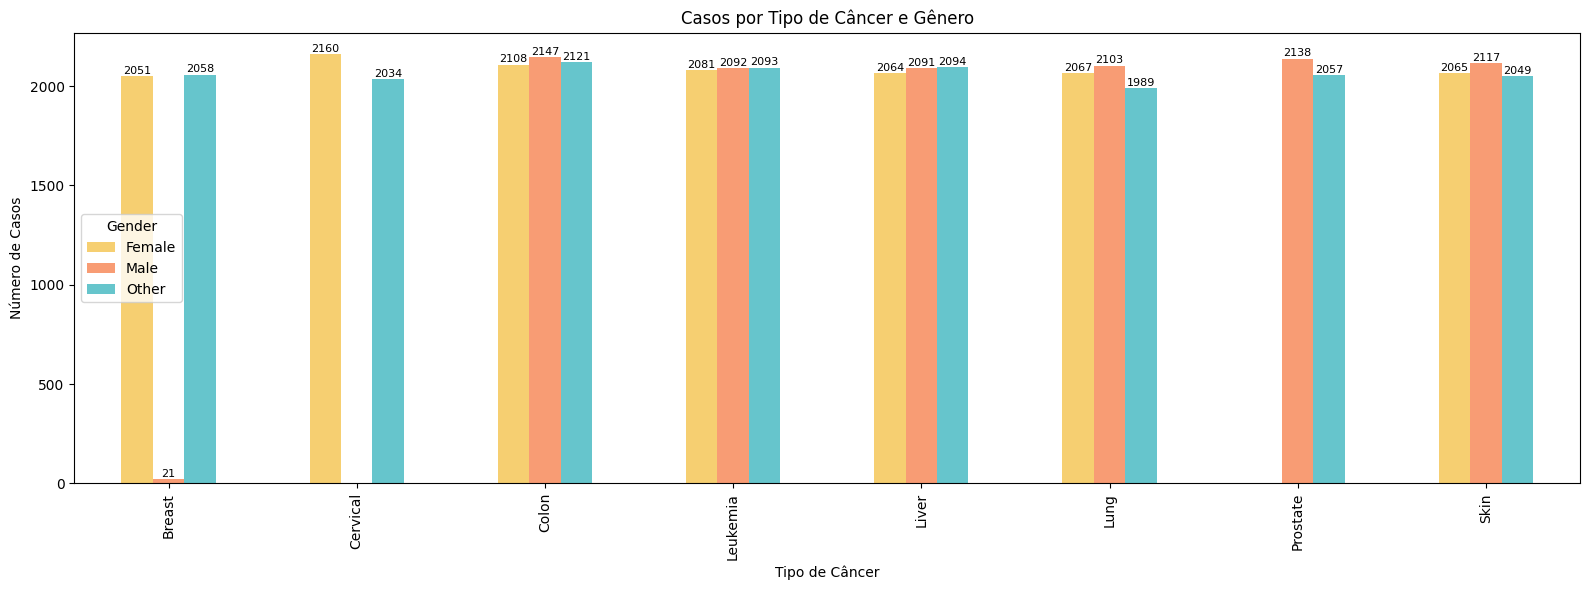

In [ ]:
# Distribuição dos casos de câncer por tipo e gênero
genero_tipo = df_cancer.groupby(['Gender', 'Cancer_Type']).size().unstack().fillna(0)

# Paleta pastel
cores_pastel = ['#f6cf71', '#f89c74','#66c5cc']

# Plot
ax = genero_tipo.T.plot(
    kind='bar',
    figsize=(16, 6),
    title='Casos por Tipo de Câncer e Gênero',
    color=cores_pastel
)

plt.ylabel('Número de Casos')
plt.xlabel('Tipo de Câncer')
plt.tight_layout()

# Rótulos nas barras
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + 1,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=8
        )

plt.show()

In [ ]:
#Proporção de cada gênero por tipo de câncer

# Contagem por tipo de câncer e gênero
contagem = df_cancer.groupby(['Cancer_Type', 'Gender']).size().reset_index(name='casos')

# Calcular proporção de cada gênero dentro de cada tipo de câncer
total_por_tipo = contagem.groupby('Cancer_Type')['casos'].transform('sum')
contagem['proporcao'] = contagem['casos'] / total_por_tipo * 100

# Gráfico de barras empilhadas normalizadas
fig = px.bar(
    contagem,
    x='Cancer_Type',
    y='proporcao',
    color='Gender',
    title='Proporção de Gêneros por Tipo de Câncer (%)',
    labels={'proporcao': 'Proporção (%)', 'Cancer_Type': 'Tipo de Câncer'},
    text=contagem['proporcao'].round(1).astype(str) + '%',
    color_discrete_map={'Male': '#f89c74',
                        'Female': '#f6cf71',
                        'Other': '#66c5cc'
                        }
)

fig.update_layout(
    barmode='stack',
    template='plotly_white',
    xaxis_tickangle=-45
)
fig.show()

In [ ]:
# Transforma os dados para formato de matriz
# Agrupar por gênero e ano
df_genero_ano = df_cancer.groupby(['Gender', 'Year'])['Target_Severity_Score'].mean().reset_index()
heatmap_df = df_genero_ano.pivot(index='Gender', columns='Year', values='Target_Severity_Score')

# Cria o heatmap
fig = px.imshow(
    heatmap_df,
    labels=dict(x="Ano", y="Gênero", color="Severidade"),
    title="Mapa de Calor da Severidade por Gênero e Ano",
    color_continuous_scale='Reds',
    aspect="auto"
)

fig.show()

###Mapa de calor global com incidência por país e ano

In [ ]:
# Agrupar dados por país e ano (contagem de casos)
incidencia = df_cancer.groupby(['Country_Region', 'Year']).size().reset_index(name='Casos')

fig = px.choropleth(
    incidencia,
    locations='Country_Region',
    locationmode='country names',
    color='Casos',
    hover_name='Country_Region',
    animation_frame='Year',
    color_continuous_scale='Reds',
    title='Incidência de Câncer por País e Ano'
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(title='Número de Casos')
)

fig.show()


In [ ]:
# Série temporal para contar número de casos por país e ano
casos_por_pais_ano = df_cancer.groupby(['Country_Region', 'Year']).size().reset_index(name='numero_de_casos')

# Descobrir os 5 países com mais casos no total
top5_paises = df_cancer['Country_Region'].value_counts().head(5).index.tolist()

# Filtrar apenas os top 5 países
casos_top5 = casos_por_pais_ano[casos_por_pais_ano['Country_Region'].isin(top5_paises)]

# Criar gráfico de linha
fig = px.line(
    casos_top5,
    x='Year',
    y='numero_de_casos',
    color='Country_Region',
    markers=True,
    title='Série Temporal da Incidência de Câncer nos 5 Países com Mais Casos',
    labels={
        'Year': 'Ano',
        'numero_de_casos': 'Número de Casos',
        'Country_Region': 'País'
    }
)

fig.update_layout(template='plotly_white')
fig.show()

In [ ]:
# Agrupar por país e ano, calculando a severidade média
df_pais = df_cancer.groupby(['Country_Region', 'Year'])['Target_Severity_Score'].mean().reset_index()

# Pivot para formato de mapa de calor
heatmap_data = df_pais.pivot(index='Country_Region', columns='Year', values='Target_Severity_Score')

# Plotar heatmap com Plotly
import plotly.express as px

fig = px.imshow(
    heatmap_data,
    labels=dict(x="Ano", y="País", color="Severidade"),
    title="Mapa de Calor da Severidade do Câncer por País e Ano",
    color_continuous_scale='Reds'
)
fig.show()

### Comparativo entre Homens, Mulheres e Outros

In [ ]:
# Agrupar por país, ano e gênero
casos = df_cancer.groupby(['Country_Region', 'Year', 'Gender']).size().reset_index(name='numero_de_casos')

# Identificar os 3 países com mais casos no total
top3_paises = df_cancer['Country_Region'].value_counts().head(3).index.tolist()

# Filtrar os dados para esses países
casos_top3 = casos[casos['Country_Region'].isin(top3_paises)]

# Definir paleta personalizada
paleta_cores = ['#f6cf71', '#f89c74', '#66c5cc']

# Criar gráfico de linhas
fig = px.line(
    casos_top3,
    x='Year',
    y='numero_de_casos',
    color='Gender',
    facet_col='Country_Region',
    facet_col_wrap=3,
    markers=True,
    text='numero_de_casos',
    title='Série Temporal da Incidência de Câncer por Gênero (Top 3 Países)',
    labels={
        'Year': 'Ano',
        'numero_de_casos': 'Número de Casos',
        'Gender': 'Gênero',
        'Country_Region': 'País'
    },
    color_discrete_sequence=paleta_cores
)

fig.update_layout(template='plotly_white')

# Ajustar posição dos rótulos nas linhas
fig.update_traces(textposition='bottom center')

# Remover prefixo "Country_Region=" dos títulos dos facetes
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.show()



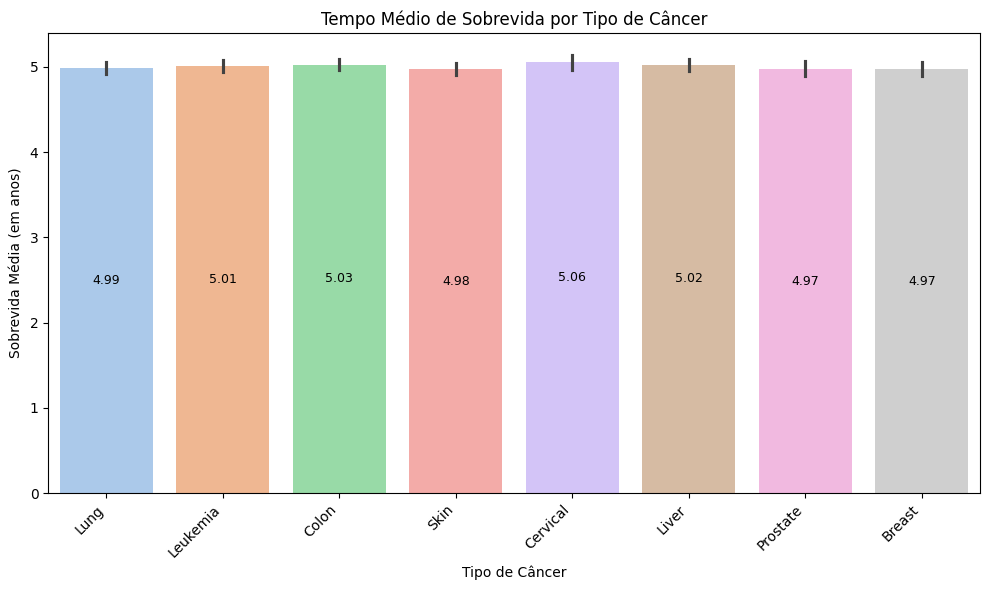

In [ ]:
# Sobrevida por tipo de cancer

# Plotar gráfico de barras
# Criar gráfico
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_cancer, x='Cancer_Type', y='Survival_Years', estimator='mean', palette='pastel')

# Adicionar rótulos nas barras
for p in ax.patches:
    altura = p.get_height()
    ax.annotate(f'{altura:.2f}',
                (p.get_x() + p.get_width() / 2., altura * 0.5),
                ha='center', va='center', fontsize=9, color='black')

plt.title('Tempo Médio de Sobrevida por Tipo de Câncer')
plt.ylabel('Sobrevida Média (em anos)')
plt.xlabel('Tipo de Câncer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Modelagem Preditiva para 2025


### Escolha da Métrica de Avaliação: MAE como Critério Principal

Como o objetivo central deste projeto é **prever o número total de casos de câncer por ano** — valores agregados e contínuos — a **métrica mais apropriada para seleção do modelo preditivo** é o **MAE (Erro Absoluto Médio)**. Um MAE menor significa que o modelo erra menos, em média.

O MAE oferece uma **medida direta da média dos erros absolutos**, permitindo compreender, de forma intuitiva, o desvio médio entre os valores previstos e os observados. Essa característica é especialmente relevante em contextos de **planejamento em saúde pública**, onde o interesse está em saber **quantos casos a mais ou a menos** estão sendo projetados, sem que variações maiores sejam excessivamente penalizadas (como ocorre no RMSE, por exemplo).

Adicionalmente, o MAE é **menos sensível a outliers**, o que o torna adequado para este conjunto de dados com distribuição **anual relativamente estável e sem grandes extremos**.

Dessa forma, neste projeto, o MAE foi adotado como **métrica principal de avaliação de desempenho**, por representar com maior fidelidade o impacto prático dos erros de previsão. O **R²** foi utilizado de forma **complementar**, fornecendo uma visão sobre a **capacidade explicativa do modelo em relação à variabilidade da série temporal**.


In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(result)
    print('Estatística ADF:', result[0])
    print('p-valor:', result[1])
    for key, value in result[4].items():
        print('Critério', key, ':', value)


test_stationarity(df_cancer['casos_por_ano'])

KeyError: 'casos_por_ano'

### Regressão Linear | Random Forest | XGBoost

In [ ]:
# Treinando, testando e avaliando os 3 modelos
# Agrupar número de casos por ano
casos_por_ano = df_cancer.groupby('Year').size().reset_index(name='numero_de_casos')

# Separar treino e teste aleatoriamente por ano (70% treino, 30% teste)
X = casos_por_ano[['Year']]
y = casos_por_ano['numero_de_casos']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Previsão para 2025
X_2025 = pd.DataFrame({'Year': [2025]})

# Treinar os modelos
modelo_lr = LinearRegression().fit(X_train, y_train)
modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
modelo_xgb = XGBRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

# Previsões nos dados de teste
y_pred_lr = modelo_lr.predict(X_test)
y_pred_rf = modelo_rf.predict(X_test)
y_pred_xgb = modelo_xgb.predict(X_test)

# Previsões para 2025
prev_lr = modelo_lr.predict(X_2025)[0]
prev_rf = modelo_rf.predict(X_2025)[0]
prev_xgb = modelo_xgb.predict(X_2025)[0]

# Função de avaliação
def avaliar(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred) ** 0.5,
        'R²': r2_score(y_true, y_pred)
    }

# Avaliação dos modelos
resultados_modelos = {
    'Regressão Linear': avaliar(y_test, y_pred_lr),
    'Random Forest': avaliar(y_test, y_pred_rf),
    'XGBoost': avaliar(y_test, y_pred_xgb)
}

# Exibir previsões
print("\n Previsão para o número de casos em 2025:")
print(f"• Regressão Linear: {int(prev_lr)} casos")
print(f"• Random Forest: {int(prev_rf)} casos")
print(f"• XGBoost: {int(prev_xgb)} casos")

# Exibir métricas
print("\n Avaliação dos modelos nos dados de teste:")
for nome, metricas in resultados_modelos.items():
    print(f"\n{nome}")
    for met, val in metricas.items():
        print(f"{met}: {val:.2f}")



 Previsão para o número de casos em 2025:
• Regressão Linear: 4337 casos
• Random Forest: 4362 casos
• XGBoost: 4404 casos

 Avaliação dos modelos nos dados de teste:

Regressão Linear
MAE: 64.38
RMSE: 75.46
R²: -0.47

Random Forest
MAE: 51.52
RMSE: 58.51
R²: 0.12

XGBoost
MAE: 55.67
RMSE: 56.38
R²: 0.18


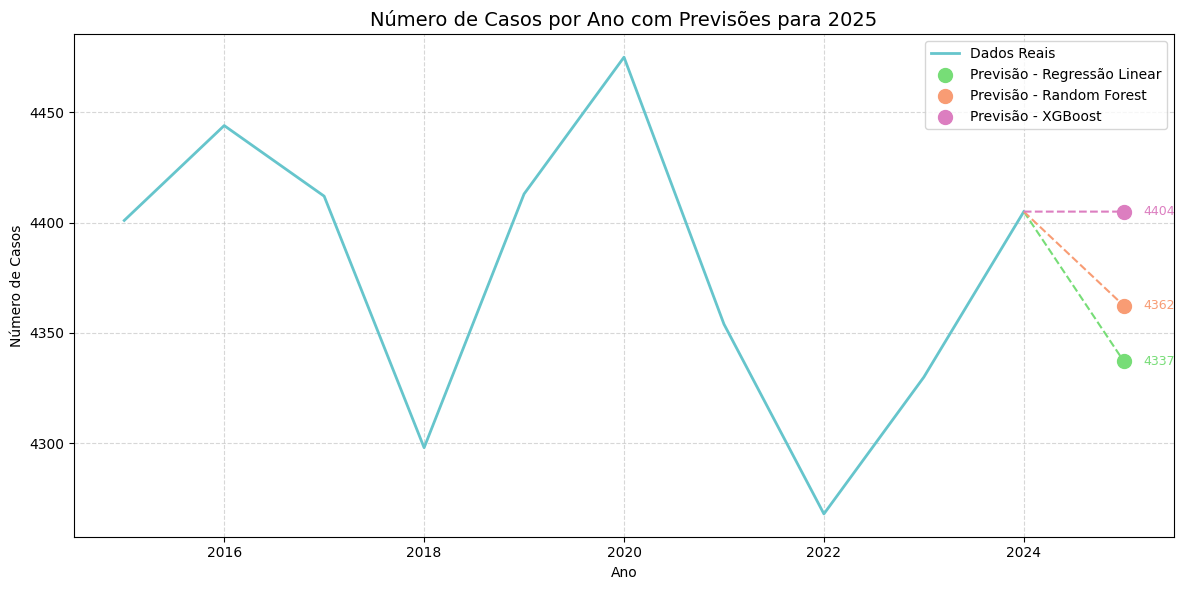

In [ ]:
# Gráfico com os dados reais e os valores previstos para cada modelo
plt.figure(figsize=(12, 6))

# Linha dos dados reais
plt.plot(casos_por_ano['Year'], casos_por_ano['numero_de_casos'], label='Dados Reais', color='#66c5cc', linewidth=2)

# Último ponto conhecido (2024)
ultimo_ano = 2024
ultimo_valor = casos_por_ano[casos_por_ano['Year'] == ultimo_ano]['numero_de_casos'].values[0]

# Previsões dos modelos
plt.scatter(2025, prev_lr, color='#77DD77', s=100, label='Previsão - Regressão Linear')
plt.scatter(2025, prev_rf, color='#f89c74', s=100, label='Previsão - Random Forest')
plt.scatter(2025, prev_xgb, color='#dc7ec0', s=100, label='Previsão - XGBoost')

# Linhas conectando o último valor real às previsões
plt.plot([2024, 2025], [ultimo_valor, prev_lr], color='#77DD77', linestyle='--')
plt.plot([2024, 2025], [ultimo_valor, prev_rf], color='#f89c74', linestyle='--')
plt.plot([2024, 2025], [ultimo_valor, prev_xgb], color='#dc7ec0', linestyle='--')

# Anotações nos pontos de previsão
plt.text(2025 + 0.2, prev_lr, f'{int(prev_lr)}', color='#77DD77', va='center', fontsize=9)
plt.text(2025 + 0.2, prev_rf, f'{int(prev_rf)}', color='#f89c74', va='center', fontsize=9)
plt.text(2025 + 0.2, prev_xgb, f'{int(prev_xgb)}', color='#dc7ec0', va='center', fontsize=9)

# Personalização do gráfico
plt.title('Número de Casos por Ano com Previsões para 2025', fontsize=14)
plt.xlabel('Ano')
plt.ylabel('Número de Casos')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Criando DataFrame com os resultados e elencando conforme performance
df_resultados = pd.DataFrame(resultados_modelos).T  # .T = transpor
df_resultados = df_resultados.round(2)

# Adicionar coluna com "ranking" por MAE (quanto menor, melhor)
df_resultados['Ranking_MAE'] = df_resultados['MAE'].rank(method='min')

# Determinar o melhor modelo (menor MAE)
melhor_modelo = df_resultados.sort_values('MAE').index[0]

# Exibir tabela completa
print("\n Comparação das Métricas dos Modelos:")
display(df_resultados)

# Exibir escolha final
print(f"\n🏆 Melhor modelo com base na menor MAE: {melhor_modelo}")



 Comparação das Métricas dos Modelos:


,MAE,RMSE,R²,Ranking_MAE
Regressão Linear,64.38,75.46,-0.47,3.0
Random Forest,51.52,58.51,0.12,1.0
XGBoost,55.67,56.38,0.18,2.0



🏆 Melhor modelo com base na menor MAE: Random Forest


## Previsão com cálculo estatístico para 2025

Nesta seção, realizamos uma projeção do número de casos de câncer para os próximos anos (2025–2030) utilizando uma abordagem estatística simples baseada na evolução histórica anual. Calculamos o crescimento médio e o desvio padrão dos casos entre 2015 e 2024, e aplicamos um intervalo de confiança de 95% (z-score = 1.96) para estimar a incerteza da projeção. Essa metodologia assume que os dados seguem um padrão aproximadamente normal e estável ao longo do tempo. O resultado é apresentado em um gráfico que mostra os valores históricos, os valores projetados e a faixa de incerteza esperada. Essa visualização ajuda a contextualizar não apenas a tendência futura, mas também o grau de confiabilidade das estimativas realizadas, sendo uma ferramenta útil para análise de risco e planejamento de políticas públicas.

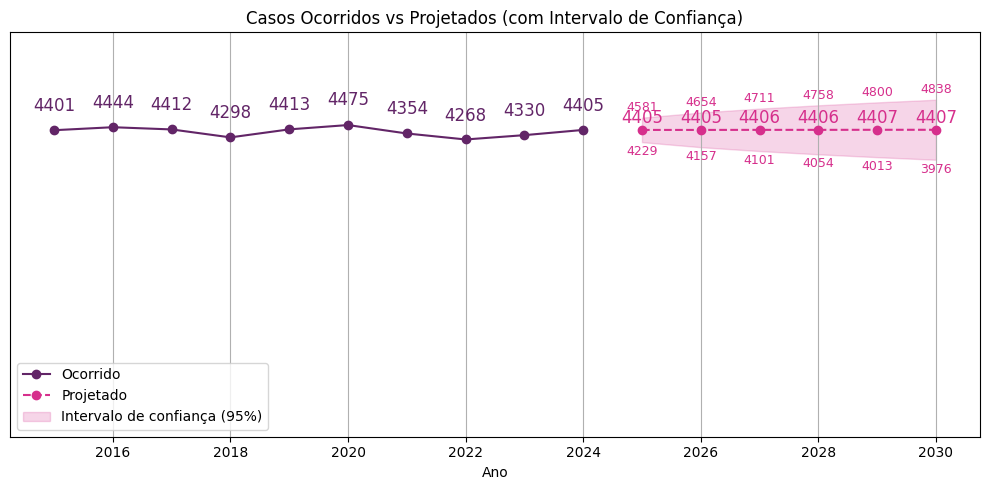

In [ ]:
# 1. Agrupar total de casos por ano
total_por_ano = df_cancer.groupby('Year').size()

# 2. Calcular o crescimento absoluto de casos ano a ano
crescimento_anual = total_por_ano.diff().dropna()

# 3. Calcular a média e o desvio padrão do crescimento
crescimento_medio = crescimento_anual.mean()
std_crescimento = crescimento_anual.std()

# 4. Projeção com intervalo de confiança
z = 1.96  # Z-score para 95% de confiança (assumindo distribuição normal)
ultimo_valor = total_por_ano.loc[2024]  # último valor conhecido
anos_futuros = range(2025, 2031)  # anos que queremos projetar
projecao = []  # lista para armazenar os resultados

for i, year in enumerate(anos_futuros, start=1):
    # Valor esperado baseado na média de crescimento
    esperado = ultimo_valor + crescimento_medio

    # Erro padrão acumulado (cresce com o tempo)
    erro_padrao = std_crescimento * np.sqrt(i)

    # Cálculo do intervalo de confiança (95%)
    intervalo_inferior = esperado - z * erro_padrao
    intervalo_superior = esperado + z * erro_padrao

    # Armazenar projeção
    projecao.append((year, int(esperado), intervalo_inferior, intervalo_superior))

    # Atualizar último valor para projetar o próximo
    ultimo_valor = esperado

# 5. Criar DataFrame com dados históricos + projetados
projecao_df = pd.concat([
    total_por_ano[total_por_ano.index <= 2024].rename('casos').to_frame(),
    pd.DataFrame(projecao, columns=['ano', 'casos', 'lower', 'upper']).set_index('ano')
])

# 6. Adicionar tag para facilitar visualização
projecao_df['tag'] = projecao_df.index.to_series().apply(
    lambda x: 'ocorrido' if x <= 2024 else 'projetado'
)

# 7. Separar histórico vs. previsão
ocorrido = projecao_df[projecao_df['tag'] == 'ocorrido']
projetado = projecao_df[projecao_df['tag'] == 'projetado']

# 8. Visualização
plt.figure(figsize=(10, 5))

# Linhas principais
plt.plot(ocorrido.index, ocorrido['casos'], label='Ocorrido', color='#622567', marker='o')
plt.plot(projetado.index, projetado['casos'], label='Projetado', color='#D62F8C', linestyle='--', marker='o')

# Área de intervalo de confiança
plt.fill_between(
    projetado.index,
    projetado['lower'],
    projetado['upper'],
    color='#D62F8C',
    alpha=0.2,
    label='Intervalo de confiança (95%)'
)

# Adicionar rótulos para os valores observados
for i, v in ocorrido['casos'].items():
    plt.text(i, v * 1.05, str(v), ha='center', va='bottom', fontsize=12, color='#622567')

# Adicionar rótulos para os valores projetados e seus intervalos
for i in projetado.index:
    valor = projetado.loc[i, 'casos']
    lower = projetado.loc[i, 'lower']
    upper = projetado.loc[i, 'upper']

    plt.text(i, valor * 1.01, f'{int(valor)}', ha='center', va='bottom', fontsize=12, color='#D62F8C')
    plt.text(i, lower * 0.99, f'{int(lower)}', ha='center', va='top', fontsize=9, color='#D62F8C')
    plt.text(i, upper * 1.01, f'{int(upper)}', ha='center', va='bottom', fontsize=9, color='#D62F8C')

# Ajustes finais do gráfico
max_val = max(projetado['upper'].max(), ocorrido['casos'].max())
plt.ylim(0, max_val * 1.2)
plt.title('Casos Ocorridos vs Projetados (com Intervalo de Confiança)')
plt.xlabel('Ano')
plt.ylabel('')
plt.yticks([])
plt.legend()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


##Impacto das variáveis

###Fatores de Risco

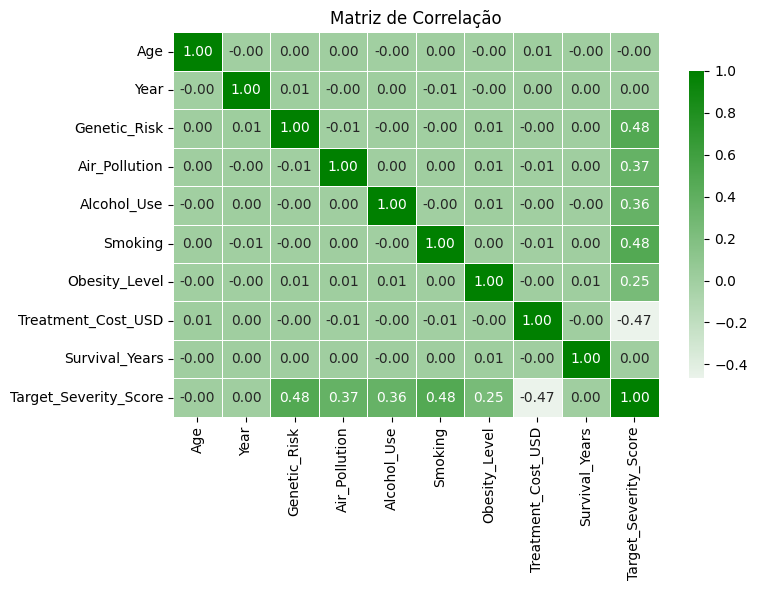


Correlação com a variável Target_Severity_Score:
Target_Severity_Score    1.000000
Smoking                  0.483867
Genetic_Risk             0.478961
Air_Pollution            0.366364
Alcohol_Use              0.362806
Obesity_Level            0.252624
Survival_Years           0.002405
Year                     0.001451
Age                     -0.002181
Treatment_Cost_USD      -0.466352
Name: Target_Severity_Score, dtype: float64


In [ ]:
# Matriz de correlação
# Seleciona colunas numéricas
num_cols = ['Age', 'Year', 'Genetic_Risk', 'Air_Pollution', 'Alcohol_Use',
            'Smoking', 'Obesity_Level', 'Treatment_Cost_USD', 'Survival_Years', 'Target_Severity_Score']

df_num = df_cancer[num_cols]

pastel_cmap = sns.light_palette("green", as_cmap=True)

# Matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(
    df_num.corr(),
    annot=True,
    cmap=pastel_cmap,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Matriz de Correlação")
plt.tight_layout()
plt.show()

# Correlação com a variável Target_Severity_Score
print("\nCorrelação com a variável Target_Severity_Score:")
print(df_num.corr()['Target_Severity_Score'].sort_values(ascending=False))


###Importância das variáveis

Comparativo de Importância entre Random Forest e XGBoost:
             Variável  Importância_RF  Importância_XGB
4             Smoking          0.2339           0.2250
1        Genetic_Risk          0.2295           0.2100
6  Treatment_Cost_USD          0.2141           0.2105
3         Alcohol_Use          0.1292           0.1396
2       Air_Pollution          0.1285           0.1376
5       Obesity_Level          0.0581           0.0763
7      Survival_Years          0.0033           0.0005
0                 Age          0.0033           0.0004


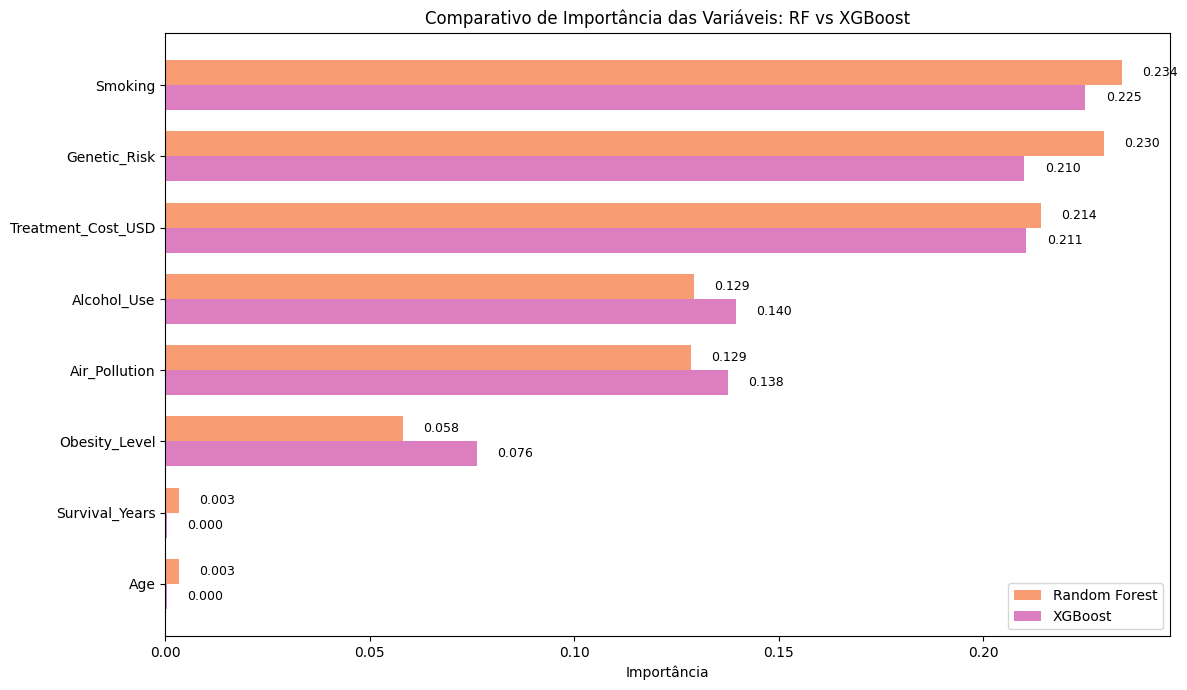

In [ ]:
# Importancia das variáveis nos modelos Random Forest e XGBoost
# Variáveis preditoras (numéricas)
colunas = ['Age','Genetic_Risk', 'Air_Pollution', 'Alcohol_Use',
            'Smoking', 'Obesity_Level','Treatment_Cost_USD', 'Survival_Years',
]

X = df_cancer[colunas]
y = df_cancer['Target_Severity_Score']

# Modelos
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

rf_model.fit(X, y)
xgb_model.fit(X, y)

# Importância das variáveis
import_rf = pd.DataFrame({
    'Variável': colunas,
    'Importância_RF': rf_model.feature_importances_
})

import_xgb = pd.DataFrame({
    'Variável': colunas,
    'Importância_XGB': xgb_model.feature_importances_
})

# Mesclar resultados
comparativo = pd.merge(import_rf, import_xgb, on='Variável')
comparativo = comparativo.sort_values(by='Importância_RF', ascending=False)

# Exibir tabela
print("Comparativo de Importância entre Random Forest e XGBoost:")
print(comparativo.round(4))

# Plotar gráfico comparativo com cores pastéis e rótulos
plt.figure(figsize=(12, 7))
bar_width = 0.35
index = range(len(comparativo))

# Cores pastéis
cor_rf = '#f89c74'
cor_xgb = '#dc7ec0'

# Barras
bars_rf = plt.barh(index, comparativo['Importância_RF'], height=bar_width, label='Random Forest', color=cor_rf)
bars_xgb = plt.barh([i + bar_width for i in index], comparativo['Importância_XGB'], height=bar_width, label='XGBoost', color=cor_xgb)

# Rótulos nas barras
for i, bar in enumerate(bars_rf):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', va='center', fontsize=9)

for i, bar in enumerate(bars_xgb):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.3f}', va='center', fontsize=9)

# Eixo e legenda
plt.yticks([i + bar_width / 2 for i in index], comparativo['Variável'])
plt.xlabel('Importância')
plt.title('Comparativo de Importância das Variáveis: RF vs XGBoost')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

##Existe diferença significativa entre a incidência de cada tipo de câncer quando comparamos homens e mulheres?

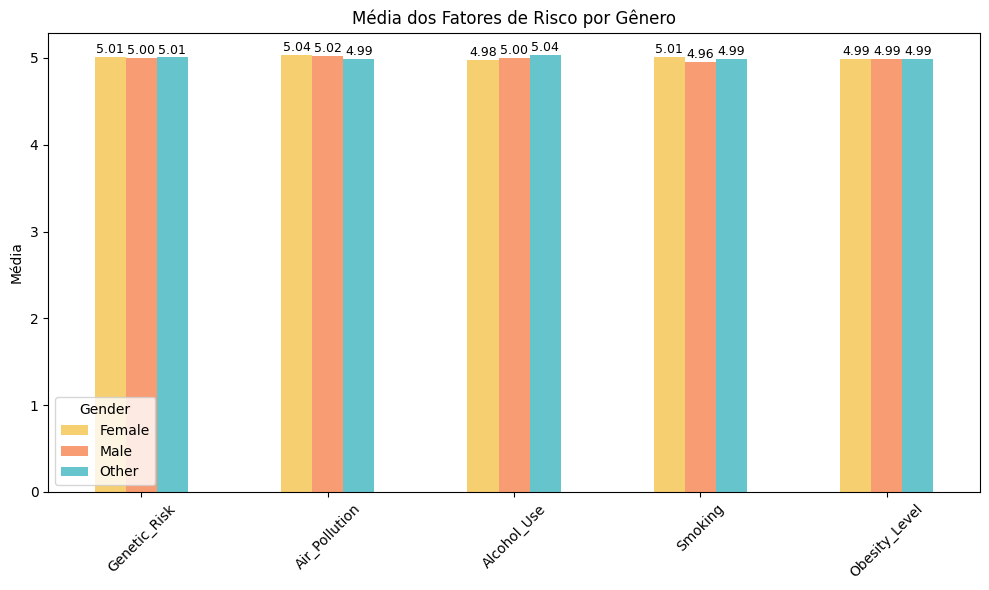

In [ ]:
# Gráfico comparativo da média dos fatores de risco por gênero
cores_pasteis = ['#f6cf71', '#f89c74', '#66c5cc']

cols_risco = ["Genetic_Risk", "Air_Pollution", "Alcohol_Use", "Smoking", "Obesity_Level"]

mean_by_gender = df_cancer[df_cancer["Gender"].isin(["Male", "Female", "Other"])].groupby("Gender")[cols_risco].mean().T

ax = mean_by_gender.plot(
    kind="bar",
    figsize=(10, 6),
    color=cores_pasteis,
    title="Média dos Fatores de Risco por Gênero"
)

plt.ylabel("Média")
plt.xticks(rotation=45)
plt.tight_layout()

# Adicionar rótulos em cima das barras
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + 0.01,
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.show()

In [ ]:
#Tipos de cancer e genero

contingencia = pd.crosstab(df_cancer['Cancer_Type'], df_cancer['Gender'])
print(contingencia)


Gender       Female  Male  Other
Cancer_Type                     
Breast         2051    21   2058
Cervical       2160     0   2034
Colon          2108  2147   2121
Leukemia       2081  2092   2093
Liver          2064  2091   2094
Lung           2067  2103   1989
Prostate          0  2138   2057
Skin           2065  2117   2049


In [ ]:
# Teste do Qui-quadrado para responder: A distribuição dos tipos de câncer varia entre gêneros?
# Esse teste verifica se existe associação entre duas variáveis categóricas (tipo de câncer e gênero)
chi2, p, dof, expected = chi2_contingency(contingencia)

print(f'Estatística qui-quadrado: {chi2:.4f}')
print(f'Valor p: {p:.4f}')

# Interpretação do resultado
if p < 0.05:
    print("\n✅ Como o valor p é menor que 0.05, rejeitamos a hipótese nula.")
    print("➡️ Há evidências estatísticas de que o tipo de câncer está associado ao gênero do paciente.")
    print("   Ou seja, a distribuição dos tipos de câncer varia entre homens e mulheres.")
else:
    print("\n❌ Como o valor p é maior que 0.05, não rejeitamos a hipótese nula.")
    print("➡️ Não há evidências suficientes para afirmar que existe associação entre o tipo de câncer e o gênero.")
    print("   As variáveis podem ser consideradas estatisticamente independentes.")

Estatística qui-quadrado: 6069.0336
Valor p: 0.0000

✅ Como o valor p é menor que 0.05, rejeitamos a hipótese nula.
➡️ Há evidências estatísticas de que o tipo de câncer está associado ao gênero do paciente.
   Ou seja, a distribuição dos tipos de câncer varia entre homens e mulheres.


# Conclusão

Este projeto teve como objetivo conduzir uma análise exploratória e preditiva sobre a evolução global do câncer entre os anos de 2015 e 2024, utilizando um conjunto de dados sintéticos com informações clínicas, demográficas e comportamentais de pacientes.

---

## Análise Exploratória e Visualizações

- **Países com maior número de casos**: Austrália, Reino Unido, Estados Unidos, Índia e Alemanha.
- **Tendência temporal**: crescimento moderado no número de casos entre 2015 e 2024.
- **Distribuição por variáveis**: idade, gênero e tipo de câncer revelaram padrões relativamente homogêneos, com pequenas variações.
- **Análise de variabilidade**: identificação de outliers e correlações com boxplots e mapas de calor.

---

## Modelagem Preditiva

- Modelos testados: Regressão Linear, Random Forest e XGBoost.
- Divisão dos dados:
  - Treino: 70% de cada ano
  - Teste: 30% de cada ano
- **Melhor modelo**: Random Forest, com menor MAE e RMSE.
- **Previsões para 2025**:
  - Random Forest: **4.362 casos**
  - Estimativa estatística: **4.405 casos**

---

## Importância das Variáveis (Random Forest e XGBoost)

Principais fatores de risco associados à severidade dos casos:

- Fumo  
- Risco genético  
- Custo do tratamento  
- Consumo de álcool  
- Poluição do ar  
- Obesidade

Essas variáveis devem ser **priorizadas em campanhas de prevenção e políticas de saúde pública**.

---

## Diferenças entre Gêneros

- **Análise visual**: pequenas variações nos tipos de câncer mais incidentes entre homens e mulheres.
- **Teste do qui-quadrado**: valor-p < 0.05 → **diferenças estatisticamente significativas**.
  - Alguns cânceres são fortemente associados ao sexo biológico (ex: mama, próstata).
- Nos demais tipos, **não há evidências robustas de desigualdade de incidência por gênero**.

---

## Propostas de Intervenção Baseadas nos Dados da Organização Mundial da Saúde (OMS)

### 1. Países de Baixo e Médio IDH  
*Exemplos: Etiópia, Zâmbia, Malaui, Tanzânia*

**Ações recomendadas**:

- **Vacinação contra HPV**: essencial para prevenção do câncer do colo do útero.
- **Programas de rastreamento (Papanicolau ou teste de HPV)**.
- **Ampliação do acesso ao tratamento oncológico básico**.
- **Campanhas educativas** sobre sintomas e prevenção.

---

### 2. Países de Alto IDH  
*Exemplos: Estados Unidos, Reino Unido, Austrália*

**Ações recomendadas**:

- Redução do tabagismo e da poluição do ar.
- Promoção de alimentação saudável e atividade física.
- Redução do consumo de álcool.
- Combate à obesidade.
- Rastreamento regular: mamografia, colonoscopia, exames de próstata.
- Monitoramento de cânceres de início precoce em adultos jovens.

---

### 3. Populações Vulneráveis Dentro de Qualquer País

**Grupos prioritários**:

- Mulheres em situação de pobreza
- Populações indígenas ou rurais
- Jovens adultos (30–40 anos)

**Medidas necessárias**:

- Acesso a exames preventivos e vacinação.
- Expansão da rede de diagnóstico precoce e tratamento.
- Inclusão de jovens adultos em diretrizes de rastreamento.

---

## Considerações Finais

A análise revelou padrões relevantes e consistentes com os dados da OMS, além de evidenciar lacunas em relação à realidade global. Portanto, as **estratégias de prevenção e controle do câncer devem**:

- **Considerar o nível de desenvolvimento de cada país**.
- **Adaptar-se às características epidemiológicas regionais**.
- **Priorizar populações mais vulneráveis**.

Com base em dados e intervenções direcionadas, é possível reduzir de forma significativa os casos e mortes por câncer em escala global.

---
